Overview: Lensing
-----------------

When two galaxies are aligned perfectly down the line-of-sight to Earth, the background galaxy's light is bent by the
intervening mass of the foreground galaxy. Its light can be fully bent around the foreground galaxy, traversing multiple
paths to the Earth, meaning that the background galaxy is observed multiple times. This by-chance alignment of two
galaxies is called a strong gravitational lens and a two-dimensional scheme of such a system is pictured below.

PyAutoLens is software designed for modeling these strong lensing systems!

To begin, lets import autolens and the plot module.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from astropy import cosmology as cosmo
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


To describe the deflection of light, **PyAutoLens** uses `Grid2D` data structures, which are two-dimensional
Cartesian grids of (y,x) coordinates. 

Below, we make and plot a uniform Cartesian grid:

In [2]:
grid = al.Grid2D.uniform(
    shape_native=(50, 50),
    pixel_scales=0.1,  # <- The pixel-scale describes the conversion from pixel units to arc-seconds.
)

Our aim is to ray-trace this `Grid2D`'s coordinates to calculate how the lens galaxy's mass deflects the source 
galaxy's light. We therefore need analytic functions representing a galaxy's light and mass distributions. 

For this,  **PyAutoLens** uses `Profile` objects, for example the `EllipticalSersic` `LightProfile` object which
represents a light distribution:

In [3]:
sersic_light_profile = al.lp.EllipticalSersic(
    centre=(0.0, 0.0),
    elliptical_comps=(0.2, 0.1),
    intensity=0.005,
    effective_radius=2.0,
    sersic_index=4.0,
)

By passing this profile a `Grid2D`, we can evaluate the light at every (y,x) coordinate on the `Grid2D` and create an 
image of the `LightProfile`.

In [4]:
image = sersic_light_profile.image_from_grid(grid=grid)

The PyAutoLens plot module provides methods for plotting objects and their properties, like the `LightProfile`'s image.

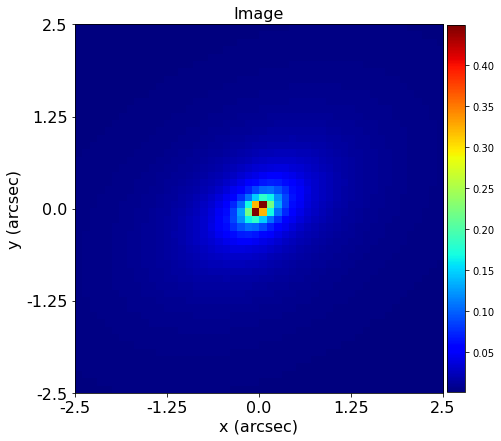

In [5]:
light_profile_plotter = aplt.LightProfilePlotter(
    light_profile=sersic_light_profile, grid=grid
)
light_profile_plotter.figures(image=True)

**PyAutoLens** uses `MassProfile` objects to represent a galaxy's mass distribution and perform ray-tracing
calculations. 

Below we create an `EllipticalIsothermal` `MassProfile` and compute its deflection angles on our Cartesian grid:

In [6]:
isothermal_mass_profile = al.mp.EllipticalIsothermal(
    centre=(0.0, 0.0), elliptical_comps=(0.1, 0.0), einstein_radius=1.6
)
deflections = isothermal_mass_profile.deflections_from_grid(grid=grid)

Lets plot the `MassProfile`'s deflection angle map.

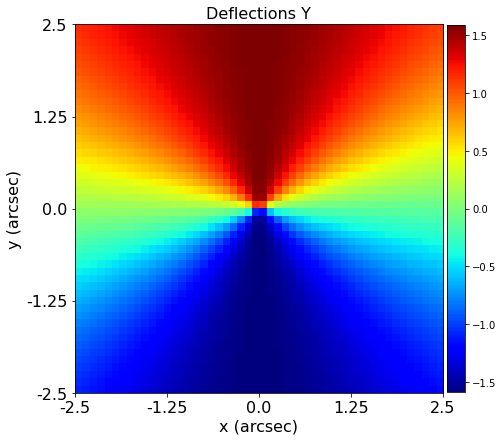

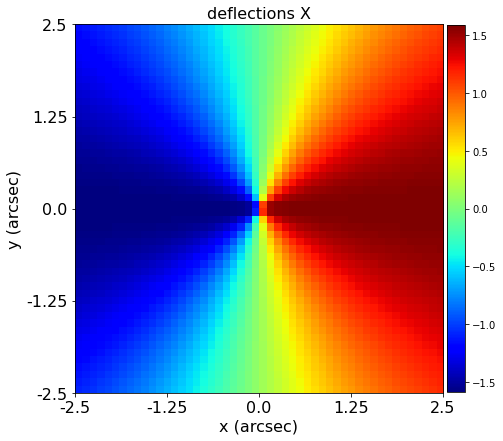

In [7]:
mass_profile_plotter = aplt.MassProfilePlotter(
    mass_profile=isothermal_mass_profile, grid=grid
)
mass_profile_plotter.figures(
    convergence=False, potential=False, deflections_y=True, deflections_x=True
)

The deflection angles describe how a given mass distribution deflects the light-rays of the source galaxy, allowing
us create strong lens systems like the one shown above!

A `Galaxy` object is a collection of `LightProfile` and `MassProfile` objects at a given redshift. The code below 
creates two galaxies representing the lens and source galaxies shown in the strong lensing diagram above.

In [8]:
lens_galaxy = al.Galaxy(
    redshift=0.5, bulge=sersic_light_profile, mass=isothermal_mass_profile
)

source_light_profile = al.lp.EllipticalExponential(
    centre=(0.3, 0.2), elliptical_comps=(0.1, 0.0), intensity=0.1, effective_radius=0.5
)

source_galaxy = al.Galaxy(redshift=1.0, bulge=source_light_profile)

The geometry of the strong lens system depends on the cosmological distances between the Earth, the lens galaxy and 
the source galaxy. It there depends on the redshifts of the `Galaxy` objects. 

By passing these `Galaxy` objects to a `Tracer`, **PyAutoLens** uses these galaxy redshifts and a cosmological model 
to create the appropriate strong lens system.

In [9]:
tracer = al.Tracer.from_galaxies(
    galaxies=[lens_galaxy, source_galaxy], cosmology=cosmo.Planck15
)

We can now create the image of a strong lens system! 

When calculating this image, the `Tracer` performs all ray-tracing for the strong lens system. This includes using the 
lens galaxy's total mass distribution to deflect the light-rays that are traced to the source galaxy. As a result, 
the source's appears as a multiply imaged and strongly lensed Einstein ring.

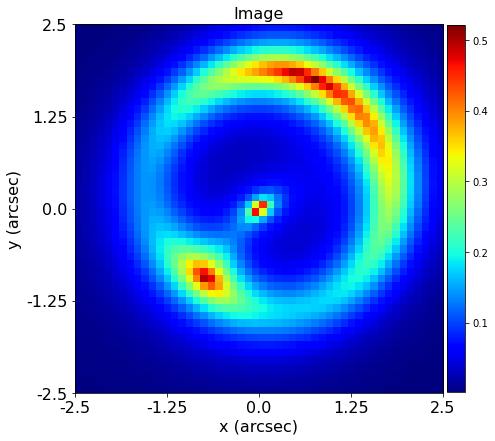

In [10]:
image = tracer.image_from_grid(grid=grid)

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures(image=True)

The `TracerPlotter` includes the `MassProfile` quantities we plotted previously, which can be plotted as a subplot 
that plots all these quantities simultaneously.

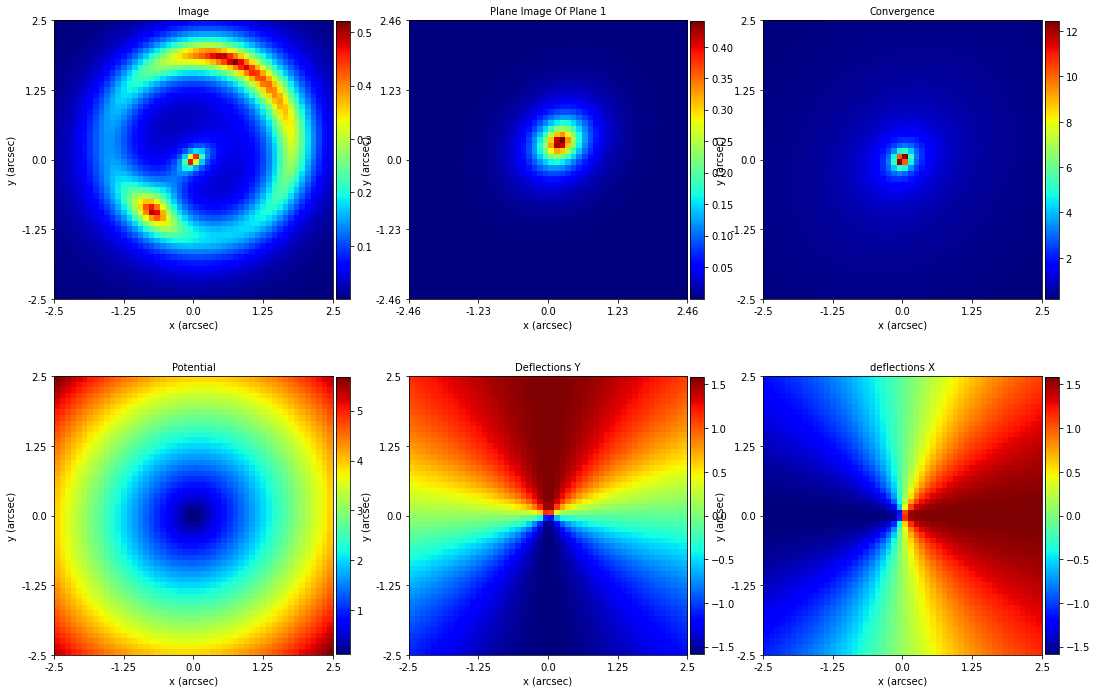

In [11]:
tracer_plotter.subplot_tracer()

The `Tracer` is composed of planes, for the system above just two planes, an image-plane (at redshift=0.5) and a 
source-plane (at redshift=1.0). When creating the image from a Tracer, the `MassProfile` is used to `ray-trace` the 
image-plane grid to the source-plane grid, via the `MassProfile`'s deflection angles.

We can use the Tracer`s traced_grid method to plot the image-plalne and source-plane grids.

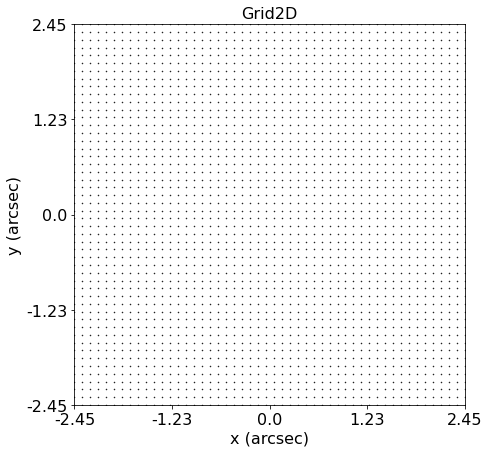

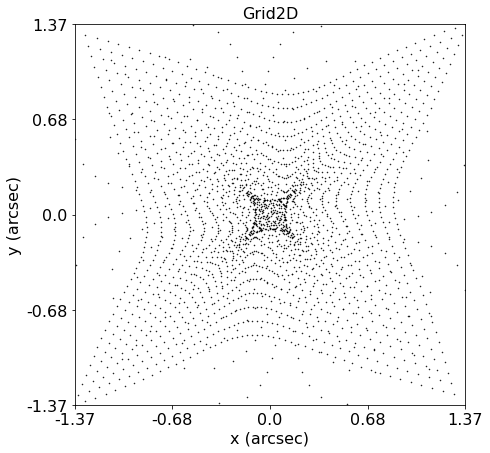

In [12]:
traced_grids = tracer.traced_grids_of_planes_from_grid(grid=grid)

grid_plotter = aplt.Grid2DPlotter(grid=traced_grids[0])
grid_plotter.figure()  # Image-plane grid.

grid_plotter = aplt.Grid2DPlotter(grid=traced_grids[1])
grid_plotter.figure()  # Source-plane grid.

The PyAutoLens API has been designed such that all of the objects introduced above are extensible. `Galaxy` objects can
take many `Profile`'s and `Tracer`'s many `Galaxy`'s. 

If the galaxies are at different redshifts a strong lensing system with multiple lens planes will be created, 
performing complex multi-plane ray-tracing calculations.

To finish, lets create a `Tracer` with 3 galaxies at 3 different redshifts, forming a system with two distinct Einstein
rings! The mass distribution of the first galaxy also has separate components for its stellar mass and dark matter.

In [13]:
lens_galaxy_0 = al.Galaxy(
    redshift=0.5,
    bulge=al.lmp.EllipticalSersic(
        centre=(0.0, 0.0),
        elliptical_comps=(0.0, 0.05),
        intensity=0.5,
        effective_radius=0.3,
        sersic_index=3.5,
        mass_to_light_ratio=0.6,
    ),
    disk=al.lmp.EllipticalExponential(
        centre=(0.0, 0.0),
        elliptical_comps=(0.0, 0.1),
        intensity=1.0,
        effective_radius=2.0,
        mass_to_light_ratio=0.2,
    ),
    dark=al.mp.SphericalNFW(centre=(0.0, 0.0), kappa_s=0.08, scale_radius=30.0),
)

lens_galaxy_1 = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalExponential(
        centre=(0.00, 0.00),
        elliptical_comps=(0.05, 0.05),
        intensity=1.2,
        effective_radius=0.1,
    ),
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), elliptical_comps=(0.05, 0.05), einstein_radius=0.6
    ),
)

source_galaxy = al.Galaxy(
    redshift=2.0,
    bulge=al.lp.EllipticalSersic(
        centre=(0.0, 0.0),
        elliptical_comps=(0.0, 0.111111),
        intensity=0.7,
        effective_radius=0.1,
        sersic_index=1.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy_0, lens_galaxy_1, source_galaxy])

This is what the lens looks like.

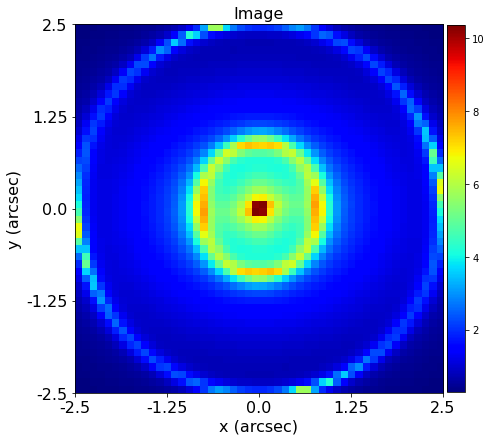

In [14]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures(image=True)

Finish.